In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
demanda_df = pd.read_csv(".\Datos\demanda.csv")

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\1703249404.py:1: SyntaxWarning: invalid escape sequence '\D'
  demanda_df = pd.read_csv(".\Datos\demanda.csv")


## Preprocesamiento

In [3]:
demanda_prod_df = demanda_df[demanda_df['id_producto']==1]
demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')

# Primero, asegurar que todas las fechas estan
# Los datos de demanda iniciales no tienen enero 2020
fecha_inicial = pd.to_datetime('2020-01-01')
fechas_df = pd.DataFrame({'date': pd.date_range(start=fecha_inicial, end=demanda_prod_df['date'].max())})
complete_demanda_prod_df = fechas_df.merge(demanda_prod_df
                                           ,how='left'
                                           ,left_on='date'
                                           ,right_on='date'
                                           )


complete_demanda_prod_df['anio'] = complete_demanda_prod_df['date'].dt.year
complete_demanda_prod_df['mes'] = complete_demanda_prod_df['date'].dt.month
complete_demanda_prod_df['dia'] = complete_demanda_prod_df['date'].dt.day
complete_demanda_prod_df['dia_de_semana'] = complete_demanda_prod_df['date'].dt.dayofweek

C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\1081254819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demanda_prod_df['date'] = pd.to_datetime(demanda_prod_df['date'], format='%Y-%m-%d')


In [4]:
# Preprocesamiento de la serie de tiempo
complete_demanda_prod_df['demanda'].ffill(inplace=True)
complete_demanda_prod_df['demanda'].bfill(inplace=True)


# Eliminacion de 29 de febrero.
complete_demanda_prod_df = complete_demanda_prod_df.sort_values(by='date', ascending=True)
complete_demanda_prod_df.reset_index(drop=True, inplace=True)

# Crear una columna indicadora para el 29 de febrero
complete_demanda_prod_df['is_feb_29'] = complete_demanda_prod_df['date'].apply(lambda x: x.month == 2 and x.day == 29)
complete_demanda_prod_df = complete_demanda_prod_df[~complete_demanda_prod_df['is_feb_29']]

C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\3688260578.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_demanda_prod_df['demanda'].ffill(inplace=True)
C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\3688260578.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [5]:
# Creacion de variables exogenas
# Encoding ciclico para variables ciclicas
complete_demanda_prod_df['mes_sin'] = np.sin(2 * np.pi *complete_demanda_prod_df['mes'] / 12)
complete_demanda_prod_df['mes_cos'] = np.cos(2 * np.pi *complete_demanda_prod_df['mes'] / 12)

complete_demanda_prod_df['dia_sin'] = np.sin(2 * np.pi *complete_demanda_prod_df['dia'] / 31)
complete_demanda_prod_df['dia_cos'] = np.cos(2 * np.pi *complete_demanda_prod_df['dia'] / 31)

complete_demanda_prod_df['dia_de_semana_sin'] = np.sin(2 * np.pi *complete_demanda_prod_df['dia_de_semana'] / 7)
complete_demanda_prod_df['dia_de_semana_cos'] = np.cos(2 * np.pi *complete_demanda_prod_df['dia_de_semana'] / 7)

# Datos booleanos transformados a enteros 1 o 0
# Flag de datos despues de aparicion de tienda de la competencia
fecha_cambio = pd.Timestamp("2021-07-02")
complete_demanda_prod_df["flg_date_despues_tienda_competencia"] = (complete_demanda_prod_df["date"] >= fecha_cambio).astype(int)

complete_demanda_prod_df['es_fin_de_semana'] = complete_demanda_prod_df['date'].dt.weekday.isin([5,6]).astype(int)
complete_demanda_prod_df['es_fin_de_semana'] = complete_demanda_prod_df['es_fin_de_semana'].astype(int)

In [6]:
# Separacion de datos antes y despues
antes_comp_df = complete_demanda_prod_df[complete_demanda_prod_df['date'] < '2021-07-02']
antes_comp_df.reset_index(inplace=True, drop=True)
despues_comp_df = complete_demanda_prod_df[complete_demanda_prod_df['date'] >= '2021-07-02']
despues_comp_df.reset_index(inplace=True, drop=True)

In [7]:
exog_cols = ['es_fin_de_semana'
             , 'mes_sin', 'mes_cos', 'dia_sin', 'dia_cos', 'dia_de_semana_sin','dia_de_semana_cos']
X_exog = complete_demanda_prod_df.loc[:, exog_cols]
X_exog_antes = antes_comp_df.loc[:, exog_cols]
X_exog_despues = despues_comp_df.loc[:, exog_cols]

In [8]:
# Evaluacion de la descomposicion de la serie con STL
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from scipy.stats import levene

C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\3800291055.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df['demanda_diff_1'] = despues_comp_df['demanda'].diff()
C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\3800291055.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df.dropna(inplace=True)


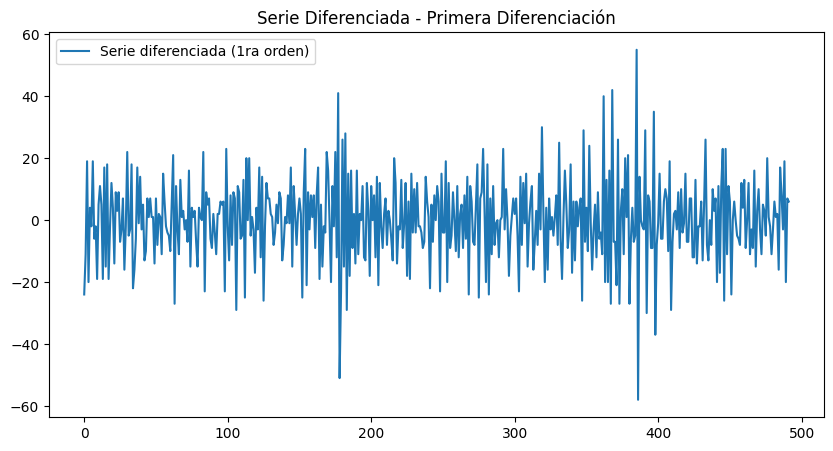

ADF Statistic: -5.282184002665841
p-value: 5.960646377284981e-06
Critical Values:
   1%: -3.444250937448703
   5%: -2.867669873870454
   10%: -2.5700349866579657

✅ La serie se volvió estacionaria con una sola diferenciación.


In [9]:
# Evaluemos si con los datos despues de la competencia, se necesita diferenciacion y si se necesita aplicar logaritmo para reducir la varianza

# Evaluacion de necesidad de diferenciacion:
# Diferenciacion de datos antes de aparicion de tienda de la competencia

# Aplicar la primera diferenciación
despues_comp_df['demanda_diff_1'] = despues_comp_df['demanda'].diff()

# Eliminar valores NaN generados por la diferenciación
despues_comp_df.dropna(inplace=True)
despues_comp_df.reset_index(inplace=True, drop=True)

# Graficar la serie diferenciada
plt.figure(figsize=(10,5))
plt.plot(despues_comp_df['demanda_diff_1'], label='Serie diferenciada (1ra orden)')
plt.legend()
plt.title('Serie Diferenciada - Primera Diferenciación')
plt.show()

# Prueba ADF en la serie diferenciada
adf_result = adfuller(despues_comp_df['demanda_diff_1'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Verificar si aún no es estacionaria (p-valor > 0.05), aplicar segunda diferenciación
if adf_result[1] > 0.05:
    print("\nLa serie sigue sin ser estacionaria. Aplicando segunda diferenciación...\n")

    # Segunda diferenciación
    despues_comp_df['demanda_diff_2'] = despues_comp_df['demanda_diff_1'].diff()
    despues_comp_df.dropna(inplace=True)
    despues_comp_df.reset_index(inplace=True, drop=True)
    # Graficar la serie diferenciada (2da orden)
    plt.figure(figsize=(10,5))
    plt.plot(despues_comp_df['demanda_diff_2'], label='Serie diferenciada (2da orden)')
    plt.legend()
    plt.title('Serie Diferenciada - Segunda Diferenciación')
    plt.show()

    # Prueba ADF en la serie diferenciada (2da orden)
    adf_result_2 = adfuller(df['demanda_diff_2'])
    print(f'ADF Statistic (2da orden): {adf_result_2[0]}')
    print(f'p-value: {adf_result_2[1]}')
    print(f'Critical Values:')
    for key, value in adf_result_2[4].items():
        print(f'   {key}: {value}')

# Verifica si ahora la serie es estacionaria
if adf_result[1] < 0.05:
    print("\n✅ La serie se volvió estacionaria con una sola diferenciación.")
elif 'adf_result_2' in locals() and adf_result_2[1] < 0.05:
    print("\n✅ La serie se volvió estacionaria con dos diferenciaciones.")
else:
    print("\n⚠️ La serie aún no es estacionaria. Considera otras transformaciones (log, sqrt).")


Sabemos que los datos despues del 2 de julio no requieren transformaciones iniciales con la prueba de Levene.

## Validacion de si es necesario algun componente estacional

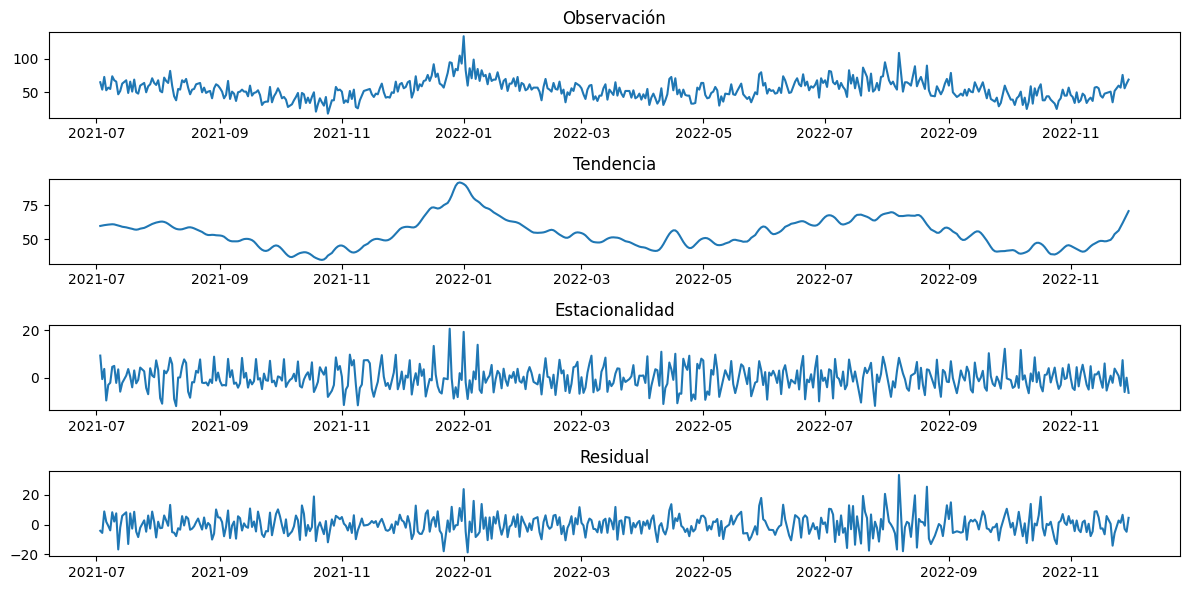

In [10]:
stl = STL(despues_comp_df['demanda'], period=7)
decomposicion = stl.fit()

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(despues_comp_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(despues_comp_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(despues_comp_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(despues_comp_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()

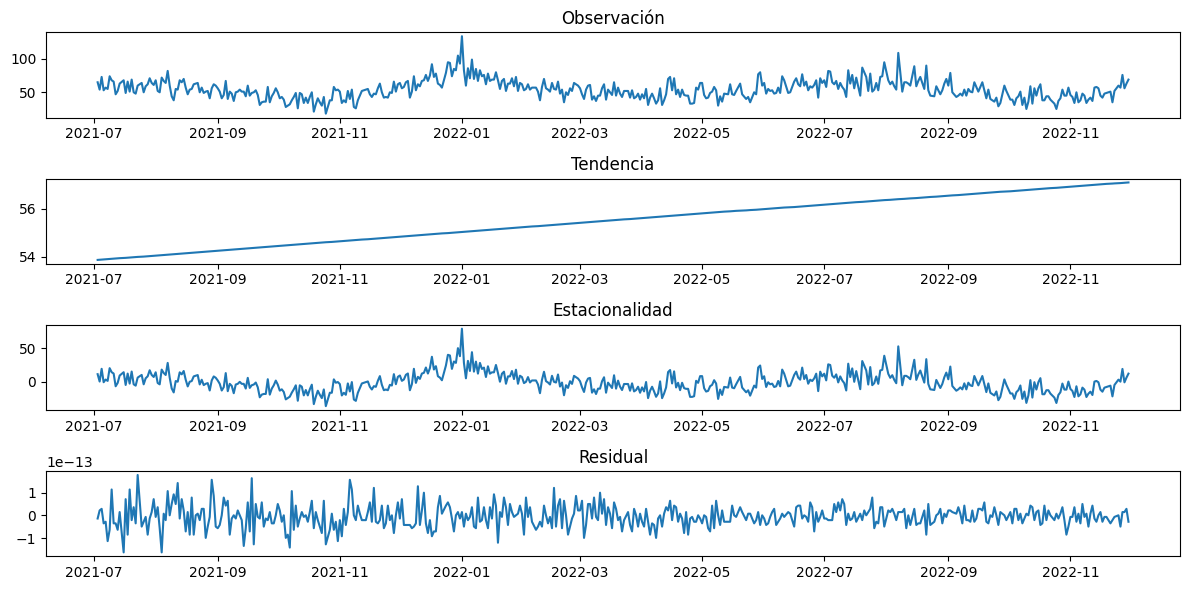

In [11]:
# Descomposicion con estacionalidad de 365 dias
stl = STL(despues_comp_df['demanda'], period=365)
decomposicion = stl.fit()

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(despues_comp_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(despues_comp_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(despues_comp_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(despues_comp_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()

## Validacion cruzada comparando modelo ARIMA vs SARIMA (`s=7`).

In [14]:
# Opcion 1, lo hacemos desde 0 con grid_search
import itertools
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

In [15]:
# ARIMA solo usa (p,d,q)
param_grid_arima = [(2, 1, q) for q in [7, 14, 21, 28]]

In [16]:
# Lista de valores permitidos para q
q = 6 # usar este para red de parametros SARIMA




S = 7  # Periodo estacional


# Diccionario con valores permitidos para Q según q
# q_Q_permitidos = {
#    7:  [2]#, 3, 4],   # Q ≠ 1
#    ,8:  [1]#, 2, 3, 4], # Todos permitidos
#    ,14: [1]#, 3, 4],   # Q ≠ 2
#    ,21: [1]#, 2, 4],   # Q ≠ 3
#    ,25: [1]#, 2, 3, 4]  # Todos permitidos
#}

# Generar combinaciones permitidas
param_grid_sarima = [
    (2, 1, q, P, 1, Q, S)
    for P in range(1,5)
    for Q in range(1,5)
]

# Validación cruzada
tscv = TimeSeriesSplit(n_splits=5)
results_arima = []
results_sarima = []


In [27]:
# Comparación ARIMA
for p, d, q in param_grid_arima:
    try:
        print(f"Ejecutando ARIMA({p},{d},{q})")
        errors = []
        for train_idx, test_idx in tscv.split(despues_comp_df['demanda']):
            train, test = despues_comp_df['demanda'][train_idx], despues_comp_df['demanda'][test_idx]
            X_exog_train = X_exog_despues.iloc[train_idx, :]
            X_exog_test = X_exog_despues.iloc[test_idx, :]

            # Modelo ARIMA
            modelo = sm.tsa.ARIMA(train, order=(p, d, q),
                                  enforce_stationarity=True,
                                  enforce_invertibility=True,
                                  exog=X_exog_train)
            modelo_fit = modelo.fit()
            predictions = modelo_fit.forecast(steps=len(test), exog=X_exog_test)

            # RMSE
            split_rmse = np.sqrt(np.mean((predictions - test) ** 2))
            errors.append(split_rmse)

        avg_rmse = np.mean(errors)
        results_arima.append(((p, d, q), avg_rmse))
        print(f"Finalizado ARIMA({p},{d},{q}) con RMSE: {avg_rmse}")
        print("----------------------------------")

    except Exception as e:
        print(f"Error en ARIMA({p},{d},{q}): {e}")
    

Ejecutando ARIMA(2,1,7)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

Finalizado ARIMA(2,1,7) con RMSE: 26.501711547167854
----------------------------------
Ejecutando ARIMA(2,1,14)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

Finalizado ARIMA(2,1,14) con RMSE: 28.057916815672854
----------------------------------
Ejecutando ARIMA(2,1,21)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

Finalizado ARIMA(2,1,21) con RMSE: 26.930723571060554
----------------------------------
Ejecutando ARIMA(2,1,28)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood opti

Finalizado ARIMA(2,1,28) con RMSE: 27.216216826916497
----------------------------------


In [ ]:
results_sarima = []

# Comparación SARIMA
for p, d, q, P, D, Q, s in param_grid_sarima:
    try:
        print(f"Ejecutando SARIMA({p},{d},{q})({P},{D},{Q},{s})")
        errors = []

        for train_idx, test_idx in tscv.split(despues_comp_df['demanda']):
            train, test = despues_comp_df['demanda'][train_idx], despues_comp_df['demanda'][test_idx]
            X_exog_train = X_exog_despues.iloc[train_idx, :]
            X_exog_test = X_exog_despues.iloc[test_idx, :]
            #print('X_exog_train.shape', X_exog_train.shape)
            #print('X_exog_test.shape', X_exog_test.shape)


            if len(train) == 0 or len(test) == 0:
                raise ValueError("Conjunto de entrenamiento o prueba vacío")

            if X_exog_train.isnull().values.any() or X_exog_test.isnull().values.any():
                raise ValueError("Existen valores NaN en X_exog_train o X_exog_test")

            # Modelo SARIMA
            modelo = sm.tsa.SARIMAX(
                train, 
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True,
                exog=X_exog_train
            )

            # modelo_fit = modelo.fit(method_kwargs={"maxiter": 300})
            modelo_fit = modelo.fit(disp=False) 
            predictions = modelo_fit.forecast(steps=len(test), exog=X_exog_test)

            # RMSE
            split_rmse = np.sqrt(np.mean((predictions - test) ** 2))
            errors.append(split_rmse)

        avg_rmse = np.mean(errors)
        results_sarima.append(((p, d, q, P, D, Q, s), avg_rmse))
        print(f"Finalizado SARIMA({p},{d},{q})({P},{D},{Q},{s}) con RMSE: {avg_rmse}")
        print("----------------------------------")

    except ValueError as ve:
        print(f"Error en SARIMA({p},{d},{q})({P},{D},{Q},{s}): ValueError - {ve}")

    except np.linalg.LinAlgError as lae:
        print(f"Error en SARIMA({p},{d},{q})({P},{D},{Q},{s}): LinAlgError - {lae}")

    except Exception as e:
        print(f"Error desconocido en SARIMA({p},{d},{q})({P},{D},{Q},{s}): {type(e).__name__} - {e}")
    


In [24]:


# Comparar los resultados
#best_arima = min(results_arima, key=lambda x: x[1])
best_sarima = min(results_sarima, key=lambda x: x[1])

#print(f"Mejor ARIMA: {best_arima[0]} con RMSE {best_arima[1]}")
print(f"Mejor SARIMA: {best_sarima[0]} con RMSE {best_sarima[1]}")


Mejor SARIMA: (2, 1, 6, 4, 1, 2, 7) con RMSE 28.537360912596263


**Conclusion**

Con 5 TS-validaciones cruzadas:
- Mejor modelo ARIMA(2,1,7) con RMSE: 26.501711547167854
- Mejor modelo SARIMAX(2, 1, 6, 4, 1, 2, 7) RMSE 28.537360912596263

# Validacion de las predicciones con test data

In [ ]:
# Validacion de entrenamiento final con datos separacion de datos para graficar predicciones y datos finales de los ultimos N dias
N_forecast = 60
y_train = despues_comp_df['demanda'][:-N_forecast]
y_test = despues_comp_df['demanda'][-N_forecast:]

X_exog = despues_comp_df.loc[:, exog_cols]
X_exog_train = X_exog.iloc[:-N_forecast, :]
X_exog_test = X_exog.iloc[-N_forecast:, :]

In [ ]:
# Entrenamiento del modelo ARIMA con mejores parametrosy en datos originales
modelo_arima = sm.tsa.arima.ARIMA(y_train, order=(2, 1, 7)
                            , enforce_stationarity=True
                            , enforce_invertibility=True
                            , exog=X_exog_train
                            )
modelo_fit = modelo_arima.fit(method_kwargs={"maxiter": 300})

# Predicciones en el conjunto de prueba
predictions_arima = modelo_fit.forecast(steps=len(y_test), exog=X_exog_test)

In [ ]:
# Entrenamiento del modelo SARIMA con mejores parametros y en datos originales
modelo_sarima = modelo = sm.tsa.SARIMAX(
                y_train, 
                order=(2, 1, 6),
                seasonal_order=(4, 1, 2, 7),
                enforce_stationarity=True,
                enforce_invertibility=True,
                exog=X_exog_train
            )

modelo_fit = modelo_sarima.fit(disp=False) 


# Predicciones en el conjunto de prueba
predictions_sarima = modelo_fit.forecast(steps=len(y_test), exog=X_exog_test)

c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [64]:
# Calculo de RMSE final ARIMA
arima_rmse_final = np.sqrt(np.mean((predictions_arima - y_test)**2))
print(f"RMSE ARIMA= {arima_rmse_final}")

# Calculo de RMSE final SARIMA
sarima_rmse_final = np.sqrt(np.mean((predictions_sarima - y_test)**2))
print(f"RMSE SARIMA= {sarima_rmse_final}")

RMSE ARIMA= 11.03203442465655
RMSE SARIMA= 22.134758711747647


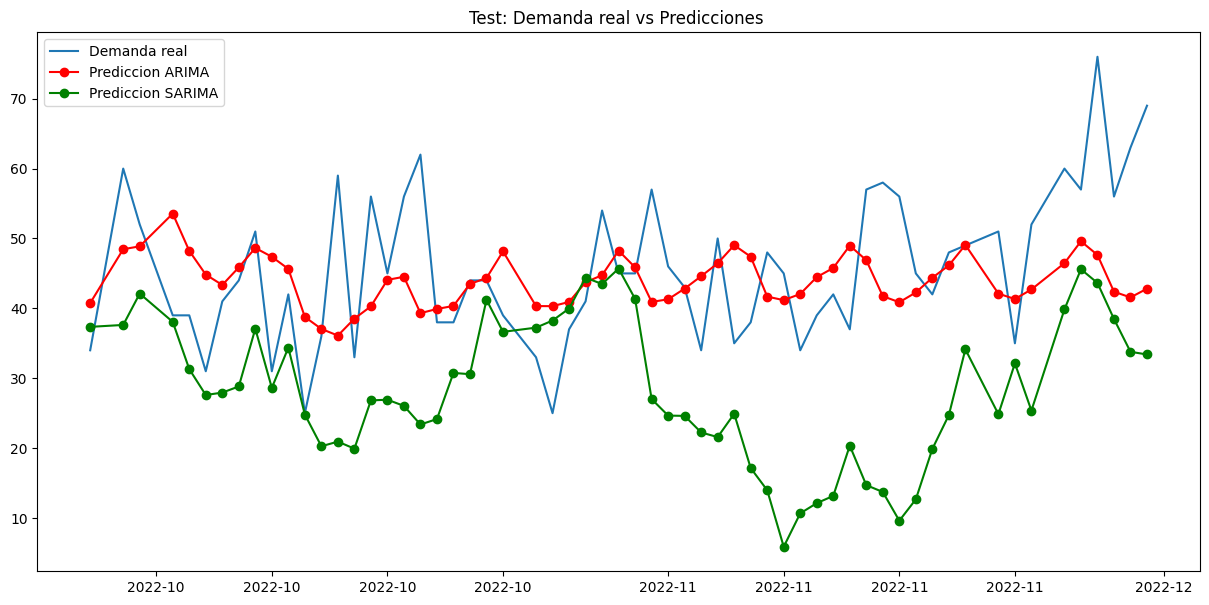

In [65]:
fig = plt.figure(figsize=(15,7))
plt.plot(despues_comp_df['date'][-N_forecast:], y_test)
plt.plot(despues_comp_df['date'][-N_forecast:], predictions_arima, color='r', marker='o')
plt.plot(despues_comp_df['date'][-N_forecast:], predictions_sarima, color='g', marker='o')


plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.title(f"Test: Demanda real vs Predicciones ")
plt.legend(['Demanda real', 'Prediccion ARIMA', 'Prediccion SARIMA'])
plt.show()

## Conclusiones con datos originales:
- ARIMA: es underfitted, SARIMA es overfitted
- Falta hacer las predicciones con solo log() y log() + StandardScaler() **HACER FUNCIONES EN MODULO DE PYTHON**

# Modulos y secciones para pipelines
1. function de evaluacion de si la serie necesita diferenciacion o no para corregir la tendencia (visualmente si tiene tendencia lineal, d=1, si parabolica, d=2)
2. la serie es estacional con visualizaciones de la ACF y PACF y la descomposicion de las serie con una estacionalidad predeterminada (s=7)
3. dependiendo de la distribucion de los datos, necesita una transformacion logaritmica o mejor una de Box - Cox
4. Modulos de TS-CV con parametros a evaluar de modelos ARIMA y SARIMA
5. Prediccion de resultados, no necesita (de momento un modulo)

## 2.1 Ejecucion de Pipeline con transformacion logaritmica
- En teoria no hace falta porque en archivo `predicciones.ipynb` validamos que con la prueba de **Levene** que la varianza no cambia.

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
# Transformacion logaritmica
despues_comp_df['log_demanda'] = np.log(despues_comp_df['demanda'] + 1)

C:\Users\juanc\AppData\Local\Temp\ipykernel_31276\1671687774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  despues_comp_df['log_demanda'] = np.log(despues_comp_df['demanda'] + 1)


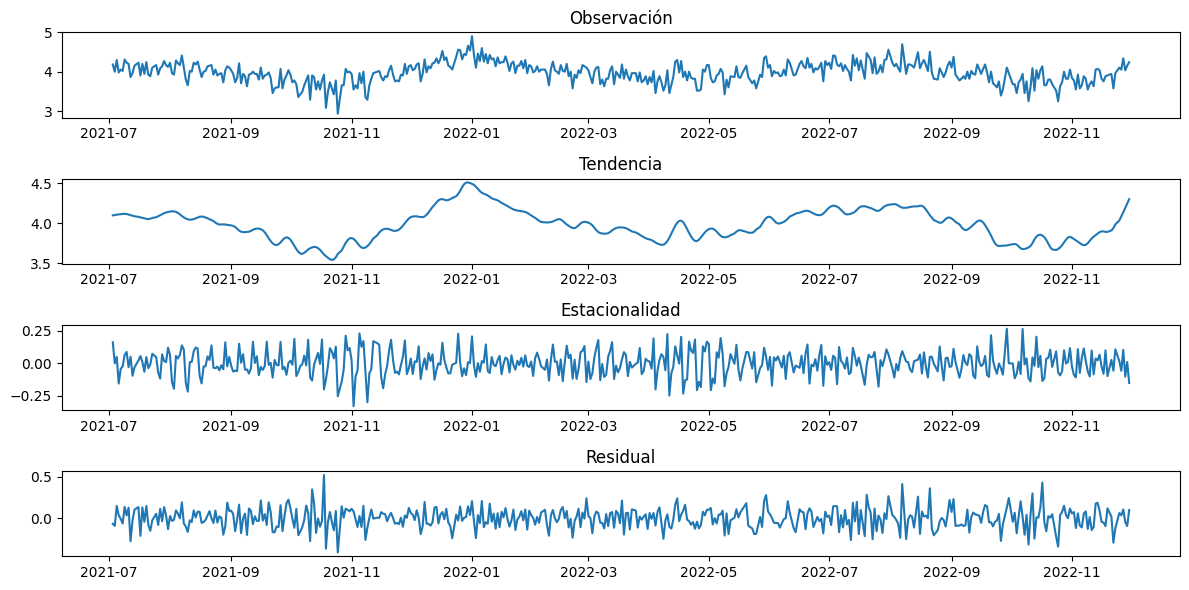

In [19]:
# Descomposicion de la serie con log_demanda, period = 7
# Revision visual de la descomposicion de los datos con STL
stl = STL(despues_comp_df['log_demanda'], period=7)
decomposicion = stl.fit()

# Graficar los componentes de la descomposición
plt.figure(figsize=(12, 6))

# Observación original
plt.subplot(411)
plt.plot(despues_comp_df['date'], decomposicion.observed)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Observación')

# Tendencia
plt.subplot(412)
plt.plot(despues_comp_df['date'], decomposicion.trend)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Tendencia')

# Estacionalidad
plt.subplot(413)
plt.plot(despues_comp_df['date'], decomposicion.seasonal)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Estacionalidad')

# Residual
plt.subplot(414)
plt.plot(despues_comp_df['date'], decomposicion.resid)
# Formatear los ticks para que muestren solo el mes y el anio
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.title('Residual')

plt.tight_layout()
plt.show()

In [20]:
# Pruebas de ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

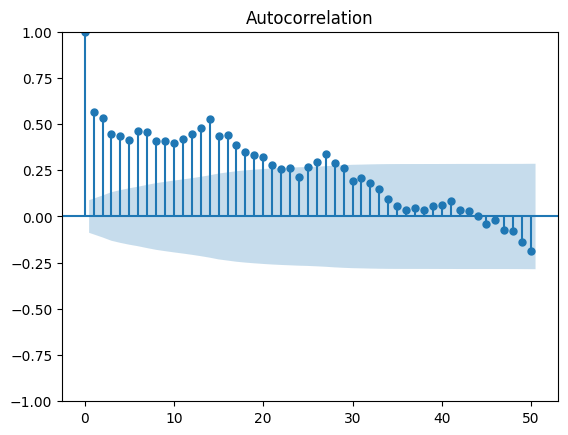

In [21]:
# Graficas de ACF y PACF
# ACF
# Funcion de autocorrelacion (ACF): verifica dependencia de ventas pasadas en ventas futuras
plot_acf(despues_comp_df['log_demanda'], lags=50)
plt.show()

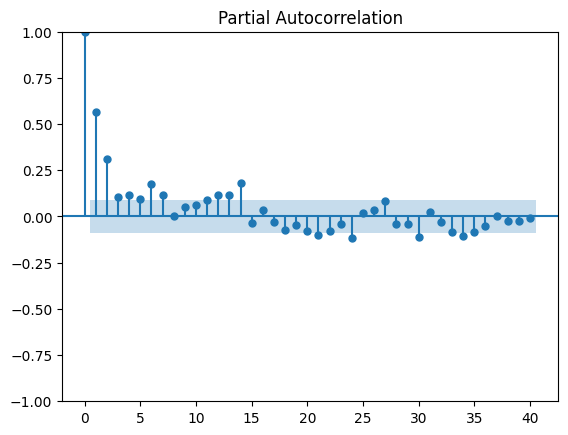

In [22]:
# Partial Autocorrelation Function (PACF): identifica que lags son relevantes
plot_pacf(despues_comp_df['log_demanda'], lags=40)
plt.show()

- Mi conclusion: q = 7 dado que lags 8 a 15 tienen una importancia similar, p = 2
- Conclusion viable (IA): (1,1,1) o (2,1,2), considerar q=0.

In [23]:
# Validacion Cruzada de modelos ARIMA con (1,1,1) y (2,1,2)
# Parámetros a probar
p_values = [1,2]  # AR
d_values = [1]  # Ya lo determinaste con ADF
q_values = [0,1,2]  # MA

# Crear combinaciones de p, d, q
param_grid = list(itertools.product(p_values, d_values, q_values))

In [83]:
# Validacion cruzada con 3 splits
tscv = TimeSeriesSplit(n_splits=3)

In [85]:
# Lista que almacena sublistas con la combinacion de (p,d,q) y el promedio de los rmse con esos valores de parametros
results = []

for p, d ,q in param_grid:
    try:
        print(f"Inicio de ejecucion con ({p},{d},{q})")
        errors = []
        for train_idx, test_idx in tscv.split(despues_comp_df['log_demanda']):
            train, test = despues_comp_df['log_demanda'][train_idx], despues_comp_df['log_demanda'][test_idx]
            X_exog = despues_comp_df.loc[:,exog_cols]
            X_exog_train = X_exog.iloc[train_idx,:]
            X_exog_test = X_exog.iloc[test_idx,:]

            # Entrenamiento del modelo ARIMA con parametros actuales
            modelo = sm.tsa.arima.ARIMA(train, order=(p, d, q)
                                        , enforce_stationarity=True
                                        , enforce_invertibility=True
                                        , exog=X_exog_train
                                        )
            modelo_fit = modelo.fit(method_kwargs={"maxiter": 300})

            # Predicciones en el conjunto de prueba
            predictions = modelo_fit.forecast(steps=len(test), exog=X_exog_test)


            # Calculo de RMSE para un split
            split_rmse = np.sqrt(np.mean((predictions - test)**2))
            errors.append(split_rmse)

        # Promedio de los errores de os splits
        avg_rmse = np.mean(errors)
        results.append(((p, d, q), avg_rmse))
        print("Entrenamiento finalizado")
        print("----------------------------------")

    except Exception as e:
        print(f"Error con la combinacion ({p},{d},{q})")
        print(e)
        print("----------------------------------")
    #    continue # en caso de error se ignora esa combinacion
        

Inicio de ejecucion con (1,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,1)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (1,1,2)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,0)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,1)
Entrenamiento finalizado
----------------------------------
Inicio de ejecucion con (2,1,2)
Entrenamiento finalizado
----------------------------------


In [87]:
results

[((1, 1, 0), np.float64(0.37845602740397527)),
 ((1, 1, 1), np.float64(0.4035344696276118)),
 ((1, 1, 2), np.float64(0.399451968553968)),
 ((2, 1, 0), np.float64(0.37670913476013407)),
 ((2, 1, 1), np.float64(0.40079872859631244)),
 ((2, 1, 2), np.float64(0.4022927166639965))]

In [88]:
# Seleccionar los mejores parámetros (menor RMSE)
best_params, best_rmse = min(results, key=lambda x: x[1])

print(f"Mejor configuración de ARIMA: {best_params} con RMSE = {best_rmse}")

Mejor configuración de ARIMA: (2, 1, 0) con RMSE = 0.37670913476013407


In [ ]:
# Cross validation para modelo SARIMA

# Generar combinaciones permitidas para SARIMA
param_grid_sarima = [
    (2, 1, 0, P, 1, Q, 7)
    for P in range(2)
    for Q in range(3)
]

In [92]:
results_sarima = []

# Comparación SARIMA
for p, d, q, P, D, Q, s in param_grid_sarima:
    try:
        print(f"Ejecutando SARIMA({p},{d},{q})({P},{D},{Q},{s})")
        errors = []

        for train_idx, test_idx in tscv.split(despues_comp_df['log_demanda']):
            train, test = despues_comp_df['log_demanda'][train_idx], despues_comp_df['log_demanda'][test_idx]
            X_exog_train = X_exog_despues.iloc[train_idx, :]
            X_exog_test = X_exog_despues.iloc[test_idx, :]
            #print('X_exog_train.shape', X_exog_train.shape)
            #print('X_exog_test.shape', X_exog_test.shape)


            if len(train) == 0 or len(test) == 0:
                raise ValueError("Conjunto de entrenamiento o prueba vacío")

            if X_exog_train.isnull().values.any() or X_exog_test.isnull().values.any():
                raise ValueError("Existen valores NaN en X_exog_train o X_exog_test")

            # Modelo SARIMA
            modelo = sm.tsa.SARIMAX(
                train, 
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=True,
                enforce_invertibility=True,
                exog=X_exog_train
            )

            # modelo_fit = modelo.fit(method_kwargs={"maxiter": 300})
            modelo_fit = modelo.fit(disp=False) 
            predictions = modelo_fit.forecast(steps=len(test), exog=X_exog_test)

            # RMSE
            split_rmse = np.sqrt(np.mean((predictions - test) ** 2))
            errors.append(split_rmse)

        avg_rmse = np.mean(errors)
        results_sarima.append(((p, d, q, P, D, Q, s), avg_rmse))
        print(f"Finalizado SARIMA({p},{d},{q})({P},{D},{Q},{s}) con RMSE: {avg_rmse}")
        print("----------------------------------")

    except ValueError as ve:
        print(f"Error en SARIMA({p},{d},{q})({P},{D},{Q},{s}): ValueError - {ve}")

    except np.linalg.LinAlgError as lae:
        print(f"Error en SARIMA({p},{d},{q})({P},{D},{Q},{s}): LinAlgError - {lae}")

    except Exception as e:
        print(f"Error desconocido en SARIMA({p},{d},{q})({P},{D},{Q},{s}): {type(e).__name__} - {e}")
    


Ejecutando SARIMA(2,1,0)(0,1,0,7)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Finalizado SARIMA(2,1,0)(0,1,0,7) con RMSE: 1.5476728389562278
----------------------------------
Ejecutando SARIMA(2,1,0)(0,1,1,7)
Finalizado SARIMA(2,1,0)(0,1,1,7) con RMSE: 0.6730547090315273
----------------------------------
Ejecutando SARIMA(2,1,0)(0,1,2,7)
Finalizado SARIMA(2,1,0)(0,1,2,7) con RMSE: 0.6503588527357723
----------------------------------
Ejecutando SARIMA(2,1,0)(1,1,0,7)
Finalizado SARIMA(2,1,0)(1,1,0,7) con RMSE: 0.583437121235126
----------------------------------
Ejecutando SARIMA(2,1,0)(1,1,1,7)
Finalizado SARIMA(2,1,0)(1,1,1,7) con RMSE: 0.6112082808424267
----------------------------------
Ejecutando SARIMA(2,1,0)(1,1,2,7)


c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Finalizado SARIMA(2,1,0)(1,1,2,7) con RMSE: 0.6318616091974948
----------------------------------


In [93]:
results_sarima

[((2, 1, 0, 0, 1, 0, 7), np.float64(1.5476728389562278)),
 ((2, 1, 0, 0, 1, 1, 7), np.float64(0.6730547090315273)),
 ((2, 1, 0, 0, 1, 2, 7), np.float64(0.6503588527357723)),
 ((2, 1, 0, 1, 1, 0, 7), np.float64(0.583437121235126)),
 ((2, 1, 0, 1, 1, 1, 7), np.float64(0.6112082808424267)),
 ((2, 1, 0, 1, 1, 2, 7), np.float64(0.6318616091974948))]

In [94]:
best_sarima = min(results_sarima, key=lambda x: x[1])

print(f"Mejor SARIMA: {best_sarima[0]} con RMSE {best_sarima[1]}")


Mejor SARIMA: (2, 1, 0, 1, 1, 0, 7) con RMSE 0.583437121235126


### Validacion de ejecucion de modelos con el test
Mejor configuración de ARIMA: (2, 1, 0) con RMSE = 0.37670913476013407

In [100]:
# Validacion de entrenamiento final con datos separacion de datos para graficar predicciones y datos finales de los ultimos N dias
N_forecast = 30
y_train = despues_comp_df['log_demanda'][:-N_forecast]
y_test = despues_comp_df['log_demanda'][-N_forecast:]

X_exog = despues_comp_df.loc[:, exog_cols]
X_exog_train = X_exog.iloc[:-N_forecast, :]
X_exog_test = X_exog.iloc[-N_forecast:, :]

In [101]:
# Entrenamiento del modelo ARIMA con mejores parametrosy en datos originales
modelo_arima = sm.tsa.arima.ARIMA(y_train, order=(2, 1, 0)
                            , enforce_stationarity=True
                            , enforce_invertibility=True
                            , exog=X_exog_train
                            )
modelo_fit = modelo_arima.fit(method_kwargs={"maxiter": 300})

# Predicciones en el conjunto de prueba
predictions_arima = modelo_fit.forecast(steps=len(y_test), exog=X_exog_test)

In [ ]:
# Entrenamiento del modelo SARIMA con mejores parametros y en datos originales
modelo_sarima = modelo = sm.tsa.SARIMAX(
                y_train, 
                order=(2, 1, 0),
                seasonal_order=(1, 1, 0, 7),
                enforce_stationarity=True,
                enforce_invertibility=True,
                exog=X_exog_train
            )

modelo_fit = modelo_sarima.fit(disp=False) 


# Predicciones en el conjunto de prueba
predictions_sarima = modelo_fit.forecast(steps=len(y_test), exog=X_exog_test)

In [103]:
# Calculo de RMSE final ARIMA
arima_rmse_final = np.sqrt(np.mean((predictions_arima - y_test)**2))
print(f"RMSE ARIMA= {arima_rmse_final}")

# Calculo de RMSE final SARIMA
sarima_rmse_final = np.sqrt(np.mean((predictions_sarima - y_test)**2))
print(f"RMSE SARIMA= {sarima_rmse_final}")

RMSE ARIMA= 0.2481206680907071
RMSE SARIMA= 0.2979431485791462


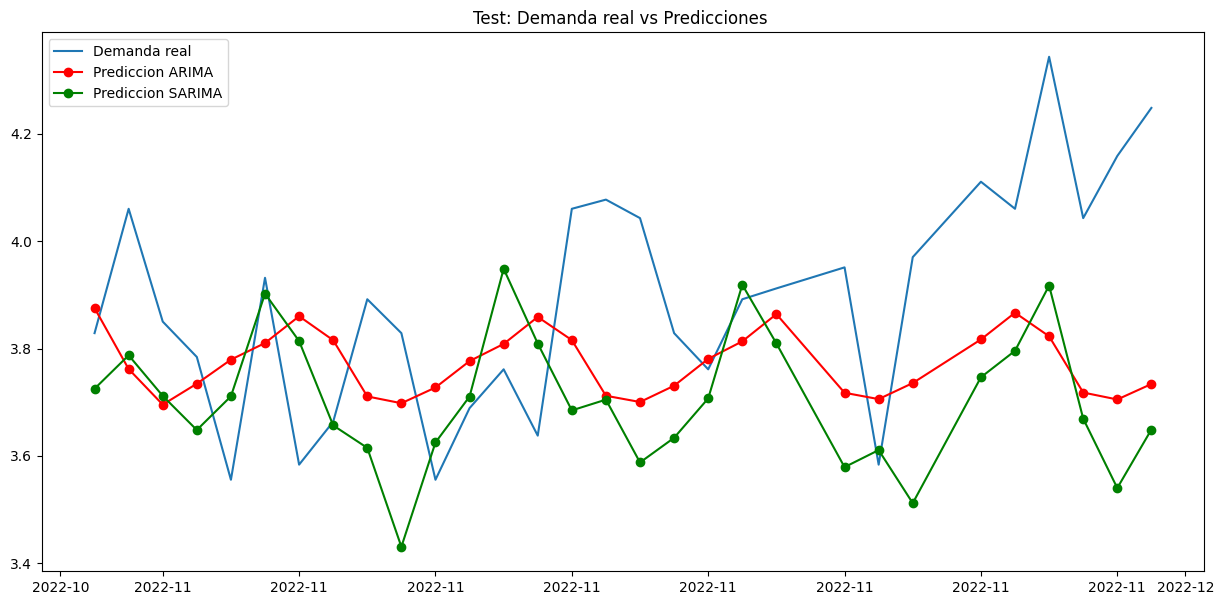

In [106]:
fig = plt.figure(figsize=(15,7))
plt.plot(despues_comp_df['date'][-N_forecast:], y_test)
plt.plot(despues_comp_df['date'][-N_forecast:], predictions_arima, color='r', marker='o')
plt.plot(despues_comp_df['date'][-N_forecast:], predictions_sarima, color='g', marker='o')


plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.title(f"Test: Demanda real vs Predicciones ")
plt.legend(['Demanda real', 'Prediccion ARIMA', 'Prediccion SARIMA'])

plt.show()

**Conclusion:**
Hay underfitting porque no hay datos suficientes. Vamos a crear datos sinteticos de dias anteriores a  al 2 de julio de 2021.

- Pros: el modelo ganara mas precicion
- Contra: asumimos que la variacion anual es constante


# Propagacion de tendencias hacia atras:

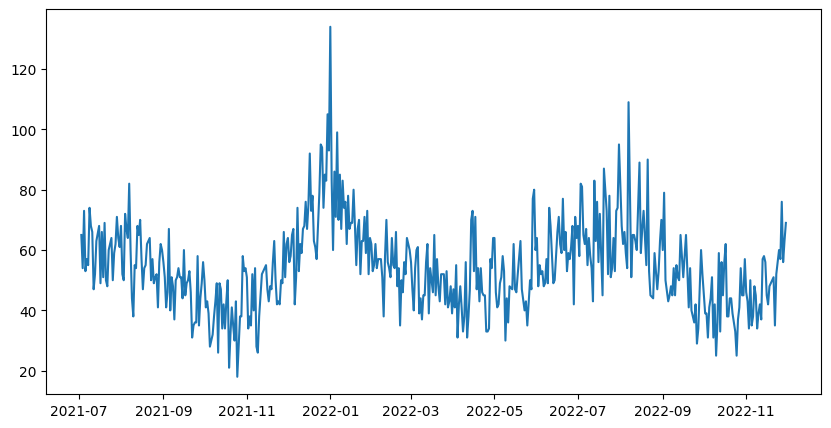

In [24]:
plt.figure(figsize=(10,5))
plt.plot(despues_comp_df['date'], despues_comp_df['demanda'])

In [25]:
# Paso 1: Calcular la variación relativa interanual
grp_despues_comp_df = despues_comp_df.groupby(['anio']).agg(
    avg_log_demanda_anual=pd.NamedAgg(column="log_demanda", aggfunc="mean")
)

In [26]:
avg_2021 = grp_despues_comp_df['avg_log_demanda_anual'][2021]
avg_2022 = grp_despues_comp_df['avg_log_demanda_anual'][2022]

var_rel_2022_2021 = (avg_2021 - avg_2022) / avg_2022

In [27]:
# Creacion de dataframe con datos ficticios
lagged_dict = {
    'date': despues_comp_df["date"][:365] - pd.DateOffset(days=365)
    ,'log_demanda': despues_comp_df["log_demanda"][:365] + despues_comp_df["log_demanda"][:365]*var_rel_2022_2021
}
ficti_df = pd.DataFrame(lagged_dict)

In [28]:
expanded_df = pd.concat([ficti_df, despues_comp_df], axis=0)
expanded_df.reset_index(inplace=True, drop=True)

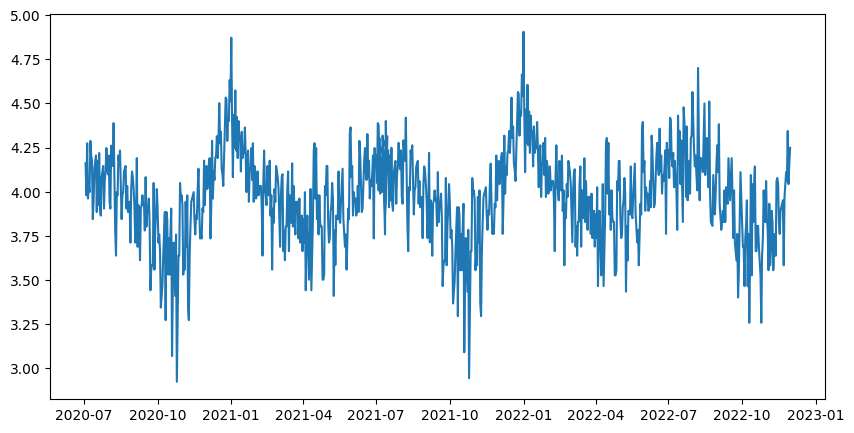

(857, 18)


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(expanded_df['date'], expanded_df['log_demanda'])
plt.show()

In [72]:
# Creacion de variables exogenas en dataset expandido
# Creacion de variables exogenas
# Encoding ciclico para variables ciclicas
expanded_df['anio'] = expanded_df['date'].dt.year
expanded_df['mes'] = expanded_df['date'].dt.month
expanded_df['dia'] = expanded_df['date'].dt.day
expanded_df['dia_de_semana'] = expanded_df['date'].dt.dayofweek

expanded_df['mes_sin'] = np.sin(2 * np.pi *expanded_df['mes'] / 12)
expanded_df['mes_cos'] = np.cos(2 * np.pi *expanded_df['mes'] / 12)

expanded_df['dia_sin'] = np.sin(2 * np.pi *expanded_df['dia'] / 31)
expanded_df['dia_cos'] = np.cos(2 * np.pi *expanded_df['dia'] / 31)

expanded_df['dia_de_semana_sin'] = np.sin(2 * np.pi *expanded_df['dia_de_semana'] / 7)
expanded_df['dia_de_semana_cos'] = np.cos(2 * np.pi *expanded_df['dia_de_semana'] / 7)

# Datos booleanos transformados a enteros 1 o 0
# Flag de datos despues de aparicion de tienda de la competencia
fecha_cambio = pd.Timestamp("2021-07-02")
expanded_df["flg_date_despues_tienda_competencia"] = (expanded_df["date"] >= fecha_cambio).astype(int)

expanded_df['es_fin_de_semana'] = expanded_df['date'].dt.weekday.isin([5,6]).astype(int)
expanded_df['es_fin_de_semana'] = expanded_df['es_fin_de_semana'].astype(int)

In [73]:
# Entrenamiento de modelos
# Validacion de entrenamiento final con datos separacion de datos para graficar predicciones y datos finales de los ultimos N dias
N_forecast = 30
y_train = expanded_df['log_demanda'][:-N_forecast]
y_test = expanded_df['log_demanda'][-N_forecast:]

X_exog = expanded_df.loc[:, exog_cols]
X_exog_train = X_exog.iloc[:-N_forecast, :]
X_exog_test = X_exog.iloc[-N_forecast:, :]

In [76]:
# Entrenamiento del modelo ARIMA con mejores parametrosy en datos originales
modelo_arima = sm.tsa.arima.ARIMA(y_train, order=(2, 1, 20)
                            , enforce_stationarity=True
                            , enforce_invertibility=True
                            , exog=X_exog_train
                            )
modelo_fit = modelo_arima.fit(method_kwargs={"maxiter": 300})

# Predicciones en el conjunto de prueba
predictions_arima = modelo_fit.forecast(steps=len(y_test), exog=X_exog_test)

c:\Users\juanc\Desktop\AI-DemandForecast\ai-forecast\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
# Calculo de RMSE final ARIMA
arima_rmse_final = np.sqrt(np.mean((predictions_arima - y_test)**2))
print(f"RMSE ARIMA= {arima_rmse_final}")

# Calculo de RMSE final SARIMA
sarima_rmse_final = np.sqrt(np.mean((predictions_sarima - y_test)**2))
print(f"RMSE SARIMA= {sarima_rmse_final}")

RMSE ARIMA= 0.24311958818697435
RMSE SARIMA= 0.26632295095098985


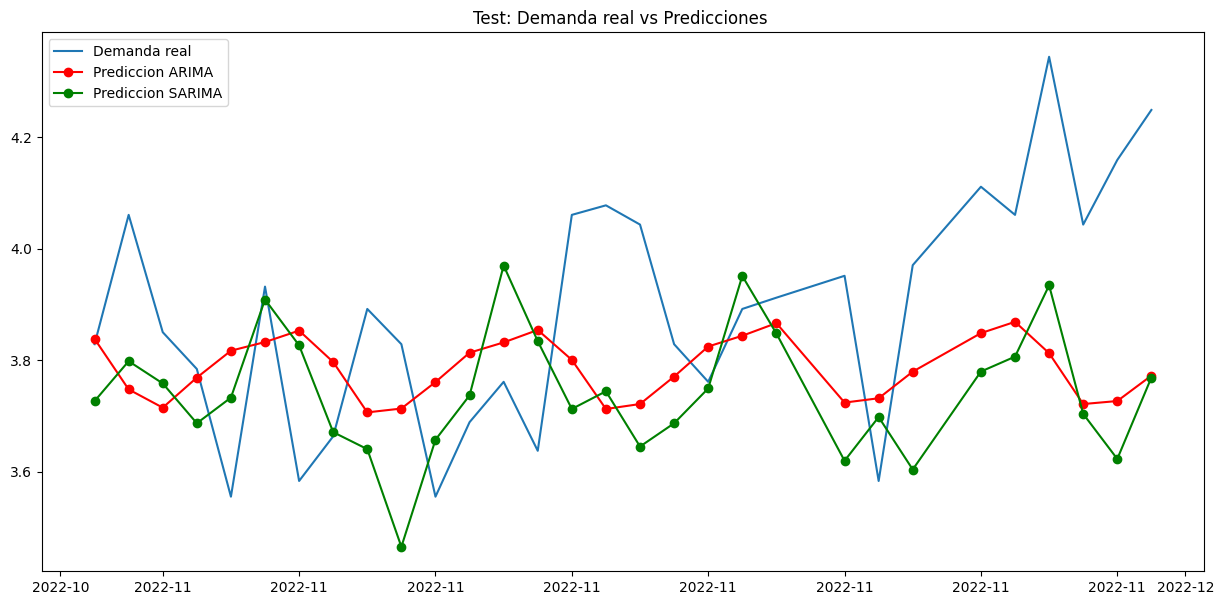

In [59]:
fig = plt.figure(figsize=(15,7))
plt.plot(expanded_df['date'][-N_forecast:], y_test)
plt.plot(expanded_df['date'][-N_forecast:], predictions_arima, color='r', marker='o')
plt.plot(expanded_df['date'][-N_forecast:], predictions_sarima, color='g', marker='o')


plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.title(f"Test: Demanda real vs Predicciones ")
plt.legend(['Demanda real', 'Prediccion ARIMA', 'Prediccion SARIMA'])

plt.show()

In [65]:
# Transformacion inversa y prediccion final
original_y_pred_arima = round(np.exp(predictions_arima) -1).astype(int)
original_y_pred_sarima = round(np.exp(predictions_sarima) -1).astype(int)
original_y_test = round(np.exp(y_test) -1).astype(int) # Buscar los datos verdaderos

In [70]:
# Calculo de RMSE final ARIMA
original_arima_rmse_final = np.sqrt(np.mean((original_y_pred_arima - original_y_test)**2))
print(f"RMSE ARIMA= {original_arima_rmse_final}")

# Calculo de RMSE final SARIMA
original_sarima_rmse_final = np.sqrt(np.mean((original_y_pred_sarima - original_y_test)**2))
print(f"RMSE SARIMA= {original_sarima_rmse_final}")

RMSE ARIMA= 12.443204303286727
RMSE SARIMA= 13.174470261329928


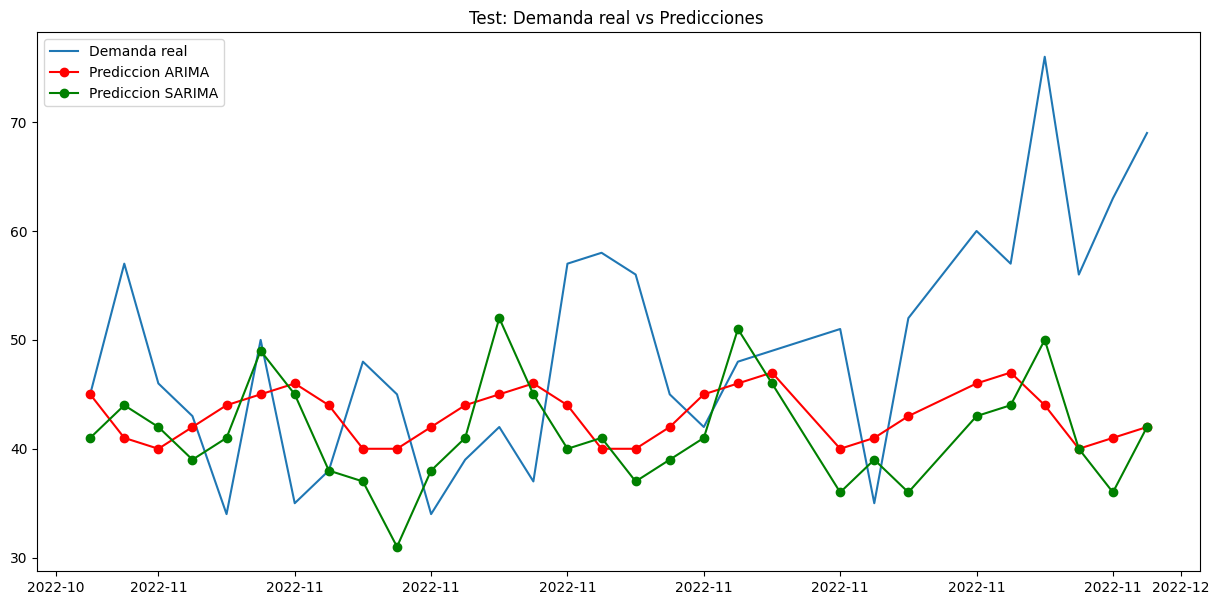

In [71]:
fig = plt.figure(figsize=(15,7))
plt.plot(expanded_df['date'][-N_forecast:], original_y_test)
plt.plot(expanded_df['date'][-N_forecast:], original_y_pred_arima, color='r', marker='o')
plt.plot(expanded_df['date'][-N_forecast:], original_y_pred_sarima, color='g', marker='o')


plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.title(f"Test: Demanda real vs Predicciones ")
plt.legend(['Demanda real', 'Prediccion ARIMA', 'Prediccion SARIMA'])

plt.show()